# 03 - Model Training (Baseline XGBoost)

In this notebook we:

1. Load the engineered per-vehicle feature matrices:
   - `train_vehicle_features.csv`
   - `validation_vehicle_features.csv`
   - `test_vehicle_features.csv`
2. Split into features (X) and labels (y).
3. Train a **baseline XGBoost classifier** with:
   - class imbalance handling via `scale_pos_weight`.
4. Evaluate performance using:
   - ROC-AUC
   - PR-AUC (average precision)
   - confusion matrix and classification report (threshold = 0.5).
5. Evaluate on both **validation** and **test** splits.

### Install dependencies

In [1]:
%pip install xgboost scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 68.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 64.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Imports & basic config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.xgboost

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

from xgboost import XGBClassifier

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.1.1) and mlflow-skinny (2.22.1) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


### Load feature matrices

In [2]:
train_path = "train_vehicle_features.csv"
val_path = "validation_vehicle_features.csv"
test_path = "test_vehicle_features.csv"

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (23550, 577)
Validation shape: (5046, 577)
Test shape: (5045, 577)


,vehicle_id,171_0_first,171_0_last,171_0_delta,171_0_mean,171_0_std,171_0_slope,171_0_r2,666_0_first,666_0_last,...,Spec_6_Cat9,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat3,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,Spec_7_Cat8,in_study_repair
0,0,167985.0,10189950.0,10021965.0,5.310002e+06,2.950191e+06,19876.641052,0.999044,10787.0,372685.0,...,0,0,0,0,0,0,0,0,0,0
1,2,65520.0,5648790.0,5583270.0,3.374853e+06,1.582802e+06,19853.231844,0.999757,2226.0,289371.0,...,0,1,0,0,0,0,0,0,0,0
2,3,1530.0,7603590.0,7602060.0,3.274506e+06,2.457206e+06,26951.993945,0.997225,28.0,230831.0,...,0,1,0,0,0,0,0,0,0,0
3,4,210915.0,4842780.0,4631865.0,1.815351e+06,1.437392e+06,28073.986439,0.946172,21371.0,210381.0,...,0,1,0,0,0,0,0,0,0,0
4,5,29175.0,6623040.0,6593865.0,2.570454e+06,1.876130e+06,17669.041399,0.986829,259.0,280531.0,...,0,1,0,0,0,0,0,0,0,0


In [3]:
import json

feature_cols = [c for c in df_train.columns if c not in ["vehicle_id", "in_study_repair"]]

with open("feature_cols.json", "w") as f:
    json.dump(feature_cols, f)

print("Saved feature_cols.json with", len(feature_cols), "columns.")

Saved feature_cols.json with 575 columns.


### Define feature/target columns

In [5]:
VEHICLE_COL = "vehicle_id"
TARGET_COL = "in_study_repair"

feature_cols = [c for c in df_train.columns if c not in [VEHICLE_COL, TARGET_COL]]

X_train = df_train[feature_cols]
y_train = df_train[TARGET_COL]

X_val = df_val[feature_cols]
y_val = df_val[TARGET_COL]

X_test = df_test[feature_cols]
y_test = df_test[TARGET_COL]

print("Number of features:", len(feature_cols))
print("Class distribution in TRAIN:")
print(y_train.value_counts(normalize=True))

Number of features: 575
Class distribution in TRAIN:
0    0.903524
1    0.096476
Name: in_study_repair, dtype: float64


### Set ML Flow experiment

In [6]:
experiment_name = "scania_pdm_baseline"
mlflow.set_experiment(experiment_name)

print("Current MLflow experiment:", experiment_name)

Current MLflow experiment: scania_pdm_baseline


### Compute class imbalance weight

In [7]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()

scale_pos_weight = neg / pos
print(f"Positive class count: {pos}")
print(f"Negative class count: {neg}")
print(f"scale_pos_weight = {scale_pos_weight:.3f}")

Positive class count: 2272
Negative class count: 21278
scale_pos_weight = 9.365


### Train baseline XGBoost model

In [8]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
)

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False,
)

print("Model trained.")

Model trained.


### Train baseline XGBoost model - MLFlow aware
* Start an MLflow run in the Azure ML workspace
* Train the model
* Compute validation ROC-AUC and PR-AUC
* Log all hyperparameters and metrics to MLflow
* Log the model artifact and registers it under the name: scania-pdm-xgb-baseline
* If the model name already exists, a new version is created under that registered model.
* Run + model can be seen in Azure ML Studio under Experiments and Models.

In [9]:
import mlflow
import mlflow.xgboost  # still fine to import, but we won't call log_model
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

experiment_name = "scania_pdm_baseline"
mlflow.set_experiment(experiment_name)

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "hist",
    "n_estimators": 300,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": float(scale_pos_weight),
    "random_state": 42,
    "n_jobs": -1,
}

with mlflow.start_run(run_name="baseline_xgb") as run:
    print("Started MLflow run:", run.info.run_id)

    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_train, y_train)

    # ---- Validation metrics ----
    y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
    roc_auc_val = roc_auc_score(y_val, y_val_proba)
    pr_auc_val = average_precision_score(y_val, y_val_proba)

    # ---- Test metrics ----
    y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    pr_auc_test = average_precision_score(y_test, y_test_proba)

    print(f"Validation ROC-AUC: {roc_auc_val:.4f}")
    print(f"Validation PR-AUC: {pr_auc_val:.4f}")
    print(f"Test ROC-AUC: {roc_auc_test:.4f}")
    print(f"Test PR-AUC: {pr_auc_test:.4f}")

    # Log hyperparameters and metrics
    mlflow.log_params(xgb_params)
    mlflow.log_metric("roc_auc_val", roc_auc_val)
    mlflow.log_metric("pr_auc_val", pr_auc_val)
    mlflow.log_metric("roc_auc_test", roc_auc_test)
    mlflow.log_metric("pr_auc_test", pr_auc_test)

    # ---- Save model locally and log as artifact ----
    model_filename = "xgb_baseline_model.pkl"
    joblib.dump(xgb_model, model_filename)

    mlflow.log_artifact(model_filename, artifact_path="model")

    print(f"Model saved locally as {model_filename} and logged to MLflow under 'model/'.")

Started MLflow run: 0ab15247-ea18-42ee-ad68-9833cd27db60
Validation ROC-AUC: 0.6997
Validation PR-AUC: 0.0490
Test ROC-AUC: 0.7020
Test PR-AUC: 0.0377
Model saved locally as xgb_baseline_model.pkl and logged to MLflow under 'model/'.
🏃 View run baseline_xgb at: https://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/52124f51-27f5-4c3c-99a9-fa716e4e8cfe/resourceGroups/scania-pdm-rg/providers/Microsoft.MachineLearningServices/workspaces/scania-pdm-ws/#/experiments/6ee59e33-cf34-46c2-ab28-a024ea958b0c/runs/0ab15247-ea18-42ee-ad68-9833cd27db60
🧪 View experiment at: https://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/52124f51-27f5-4c3c-99a9-fa716e4e8cfe/resourceGroups/scania-pdm-rg/providers/Microsoft.MachineLearningServices/workspaces/scania-pdm-ws/#/experiments/6ee59e33-cf34-46c2-ab28-a024ea958b0c


In [2]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Model

SUBSCRIPTION_ID = "52124f51-27f5-4c3c-99a9-fa716e4e8cfe"
RESOURCE_GROUP = "scania-pdm-rg"
WORKSPACE_NAME = "scania-pdm-ws"
model_filename = "xgb_baseline_model.pkl"

# Create ML client
ml_client = MLClient(
    DefaultAzureCredential(),
    SUBSCRIPTION_ID,
    RESOURCE_GROUP,
    WORKSPACE_NAME,
)

# Register the local pickle file as a model
model = Model(
    name="scania-pdm-xgb-baseline",
    path=model_filename,          # local file; SDK uploads it for you
    type="custom_model",          # plain pickle
    description="Baseline XGBoost model for Scania predictive maintenance",
    tags={
        "stage": "baseline",
        "framework": "xgboost",
        "task": "binary_classification",
        "target": "imminent_failure_within_6_timesteps",
    },
)

registered_model = ml_client.models.create_or_update(model)
print("Registered model:", registered_model.name)
print("Version:", registered_model.version)
print("Path in workspace:", registered_model.path)


Uploading xgb_baseline_model.pkl (< 1 MB): 100%|██████████| 774k/774k [00:00<00:00, 23.3MB/s]




Registered model: scania-pdm-xgb-baseline
Version: 1
Path in workspace: azureml://subscriptions/52124f51-27f5-4c3c-99a9-fa716e4e8cfe/resourceGroups/scania-pdm-rg/workspaces/scania-pdm-ws/datastores/workspaceblobstore/paths/LocalUpload/02e5d7648b0b58f9fb0878e27a958e3e8f1c002dcaeed3b73ab1a837a08bd8d8/xgb_baseline_model.pkl


Getting a list of installed libraries:

In [10]:
import sys
import pkgutil

print("Python:", sys.version)
print("Installed packages:")
for m in pkgutil.iter_modules():
    print(m.name)

Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
Installed packages:
__future__
_aix_support
_bootsubprocess
_collections_abc
_compat_pickle
_compression
_markupbase
_osx_support
_py_abc
_pydecimal
_pyio
_sitebuiltins
_strptime
_sysconfigdata__linux_x86_64-linux-gnu
_sysconfigdata_x86_64_conda_cos6_linux_gnu
_sysconfigdata_x86_64_conda_linux_gnu
_threading_local
_weakrefset
abc
aifc
antigravity
argparse
ast
asynchat
asyncio
asyncore
base64
bdb
binhex
bisect
bz2
cProfile
calendar
cgi
cgitb
chunk
cmd
code
codecs
codeop
collections
colorsys
compileall
concurrent
configparser
contextlib
contextvars
copy
copyreg
crypt
csv
ctypes
curses
dataclasses
datetime
dbm
decimal
difflib
dis
distutils
doctest
email
encodings
ensurepip
enum
filecmp
fileinput
fnmatch
fractions
ftplib
functools
genericpath
getopt
getpass
gettext
glob
graphlib
gzip
hashlib
heapq
hmac
html
http
idlelib
imaplib
imghdr
imp
importlib
inspect
io
ipaddress
json
keyword
lib2to3
linecache
locale
logging
lzma
mailbox
mail

### Evaluation helper function

In [10]:
def evaluate_model(model, X, y, split_name=""):
    """
    Compute metrics and plots for a given split.
    """
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    roc_auc = roc_auc_score(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)

    print(f"=== {split_name} metrics ===")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC (Average Precision): {pr_auc:.4f}")
    print("\nConfusion matrix (threshold=0.5):")
    print(confusion_matrix(y, y_pred))
    print("\nClassification report:")
    print(classification_report(y, y_pred, digits=4))

    # ROC curve
    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f"ROC curve ({split_name})")
    plt.show()

    # PR curve
    PrecisionRecallDisplay.from_predictions(y, y_proba)
    plt.title(f"Precision-Recall curve ({split_name})")
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
    }

### Evaluate on TRAIN and VALIDATION

In [11]:
print("y_val value counts (including NaNs):")
print(y_val.value_counts(dropna=False))

y_val value counts (including NaNs):
0    4970
1      76
Name: in_study_repair, dtype: int64


=== TRAIN metrics ===
ROC-AUC: 0.9884
PR-AUC (Average Precision): 0.9043

Confusion matrix (threshold=0.5):
[[19436  1842]
 [   34  2238]]

Classification report:
              precision    recall  f1-score   support

           0     0.9983    0.9134    0.9540     21278
           1     0.5485    0.9850    0.7047      2272

    accuracy                         0.9203     23550
   macro avg     0.7734    0.9492    0.8293     23550
weighted avg     0.9549    0.9203    0.9299     23550



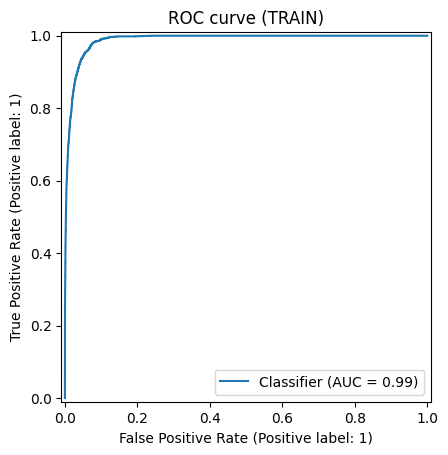

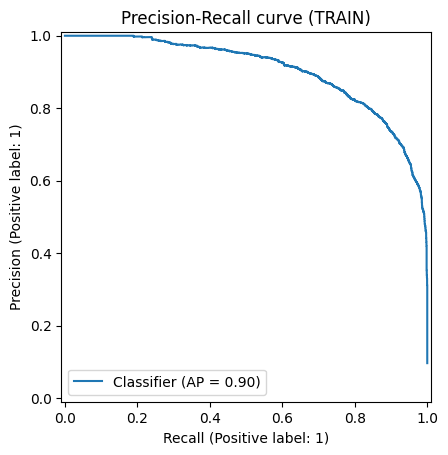

=== VALIDATION metrics ===
ROC-AUC: 0.6997
PR-AUC (Average Precision): 0.0490

Confusion matrix (threshold=0.5):
[[3765 1205]
 [  40   36]]

Classification report:
              precision    recall  f1-score   support

           0     0.9895    0.7575    0.8581      4970
           1     0.0290    0.4737    0.0547        76

    accuracy                         0.7533      5046
   macro avg     0.5092    0.6156    0.4564      5046
weighted avg     0.9750    0.7533    0.8460      5046



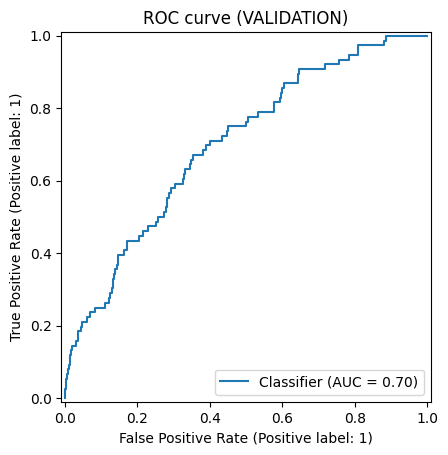

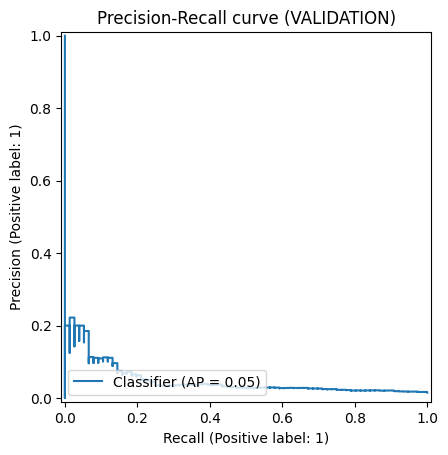

({'roc_auc': 0.9883816303687337, 'pr_auc': 0.9043351442465056},
 {'roc_auc': 0.6996611246425924, 'pr_auc': 0.04895880530548845})

In [12]:
metrics_train = evaluate_model(xgb_model, X_train, y_train, split_name="TRAIN")
metrics_val = evaluate_model(xgb_model, X_val, y_val, split_name="VALIDATION")

metrics_train, metrics_val

### Final evaluation on TEST

=== TEST metrics ===
ROC-AUC: 0.7020
PR-AUC (Average Precision): 0.0377

Confusion matrix (threshold=0.5):
[[3445 1540]
 [  26   34]]

Classification report:
              precision    recall  f1-score   support

           0     0.9925    0.6911    0.8148      4985
           1     0.0216    0.5667    0.0416        60

    accuracy                         0.6896      5045
   macro avg     0.5071    0.6289    0.4282      5045
weighted avg     0.9810    0.6896    0.8056      5045



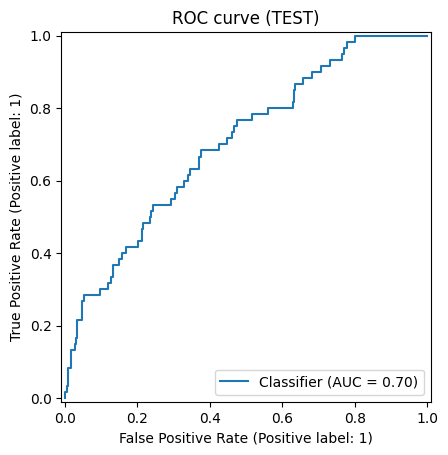

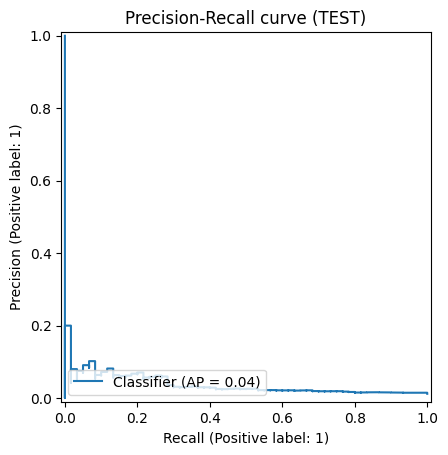

{'roc_auc': 0.7019959879638917, 'pr_auc': 0.037738751831773366}

In [13]:
metrics_test = evaluate_model(xgb_model, X_test, y_test, split_name="TEST")
metrics_test

### Save the model

In [ ]:
import joblib

model_path = "xgb_scania_model.pkl"
joblib.dump(
    {
        "model": xgb_model,
        "feature_cols": feature_cols,
        "scale_pos_weight": scale_pos_weight,
    },
    model_path,
)

print(f"Saved model to: {model_path}")

In [29]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.01, 0.99, 20)

for t in thresholds:
    y_pred = (xgb_model.predict_proba(X_val)[:, 1] >= t).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    print(f"t={t:.2f}: precision={precision:.3f}, recall={recall:.3f}")

t=0.01: precision=0.015, recall=1.000
t=0.06: precision=0.017, recall=1.000
t=0.11: precision=0.018, recall=0.974
t=0.16: precision=0.019, recall=0.921
t=0.22: precision=0.021, recall=0.908
t=0.27: precision=0.021, recall=0.789
t=0.32: precision=0.023, recall=0.750
t=0.37: precision=0.026, recall=0.711
t=0.42: precision=0.028, recall=0.645
t=0.47: precision=0.027, recall=0.500
t=0.53: precision=0.031, recall=0.447
t=0.58: precision=0.036, recall=0.395
t=0.63: precision=0.034, recall=0.289
t=0.68: precision=0.039, recall=0.250
t=0.73: precision=0.050, recall=0.237
t=0.78: precision=0.062, recall=0.197
t=0.84: precision=0.078, recall=0.145
t=0.89: precision=0.105, recall=0.105
t=0.94: precision=0.174, recall=0.053
t=0.99: precision=0.000, recall=0.000
